In [17]:
import pandas as pd

# Carregar dados
df_pedidos = pd.read_csv('../data/processed/pedidos.csv')

# Contar número de pedidos por cliente
pedidos_por_cliente = df_pedidos.groupby('customer_id')['order_id'].nunique()

# Calcular clientes recorrentes
clientes_recorrentes = pedidos_por_cliente[pedidos_por_cliente > 1].count()

# Calcular total de clientes
total_clientes = df_pedidos['customer_id'].nunique()

# Taxa de retenção
taxa_retencao = (clientes_recorrentes / total_clientes) * 100

# Exibir a taxa de retenção
print(f'Taxa de Retenção: {taxa_retencao:.2f}%')

# Insights baseados na taxa de retenção
if taxa_retencao == 0:
    print("Insight: Nenhuma retenção de clientes. A empresa deve investigar as causas dessa baixa retenção e agir rapidamente para melhorar a fidelização.")
elif 0 < taxa_retencao <= 20:
    print("Insight: Retenção muito baixa. Estratégias de fidelização, como descontos, ofertas especiais e programas de fidelidade, devem ser consideradas.")
elif 20 < taxa_retencao <= 50:
    print("Insight: Retenção moderada. É necessário melhorar as estratégias para fidelizar clientes, como melhorar a experiência do cliente e ofertas de longo prazo.")
else:
    print("Insight: Boa taxa de retenção. A empresa está indo bem. O foco pode ser em melhorar ainda mais a experiência do cliente e consolidar a fidelidade.")


Taxa de Retenção: 0.00%
Insight: Nenhuma retenção de clientes. A empresa deve investigar as causas dessa baixa retenção e agir rapidamente para melhorar a fidelização.


Relatório de Classificação:

              precision    recall  f1-score   support

    No prazo       0.99      0.92      0.95     26593
    Atrasado       0.49      0.85      0.62      2346

    accuracy                           0.92     28939
   macro avg       0.74      0.89      0.79     28939
weighted avg       0.95      0.92      0.93     28939



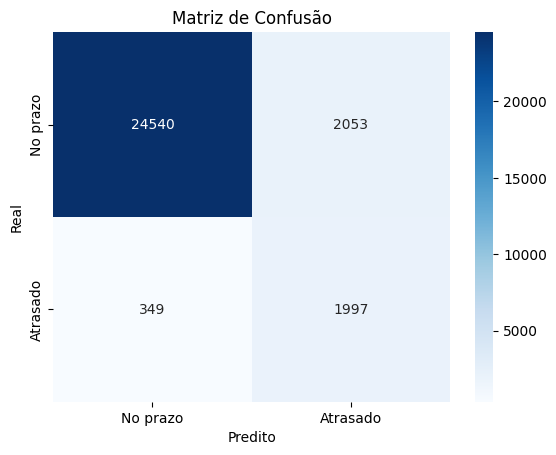

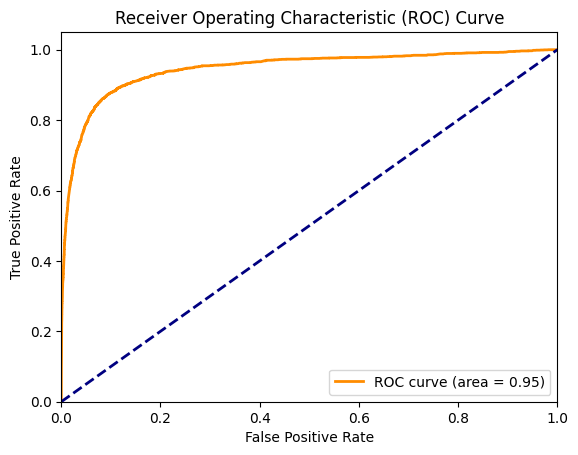

In [15]:
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar datasets
orders = pd.read_csv('../data/processed/pedidos.csv', parse_dates=['order_delivered_customer_date', 'order_estimated_delivery_date', 'order_approved_at'])
items = pd.read_csv('../data/processed/itens.csv', usecols=['order_id', 'freight_value'])

# Agregar valor de frete por pedido
freight_by_order = items.groupby('order_id')['freight_value'].sum().reset_index()

# Merge com dados de frete
df = orders.merge(freight_by_order, on='order_id', how='left')

# Criar variável alvo: 1 = atrasado, 0 = no prazo
df['delayed'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)

# Nova feature: tempo de pedido até a entrega
df['order_to_delivery_time'] = (df['order_delivered_customer_date'] - df['order_approved_at']).dt.days

# Remover valores ausentes
model_data = df[['order_to_delivery_time', 'freight_value', 'delayed']].dropna()

# Features e alvo
X = model_data[['order_to_delivery_time', 'freight_value']]
y = model_data['delayed']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Otimização de hiperparâmetros com GridSearchCV (simplificado)
param_grid = {
    'n_estimators': [50, 100],  # Reduzir para 2 valores
    'max_depth': [5, 10],        # Reduzir para 2 valores
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_

# Predizer
y_pred = best_model.predict(X_test)

# Relatório de classificação
report = classification_report(y_test, y_pred, target_names=['No prazo', 'Atrasado'], zero_division=0)
print("Relatório de Classificação:\n")
print(report)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No prazo', 'Atrasado'], yticklabels=['No prazo', 'Atrasado'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# AUC e ROC Curve
y_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plotar curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



Média das métricas por cluster:

         Recency  Frequency  Monetary
Cluster                              
0         136.08        1.0    137.30
1         304.20        1.0    130.82
2         508.16        1.0    132.99
3         290.64        1.0   1142.90


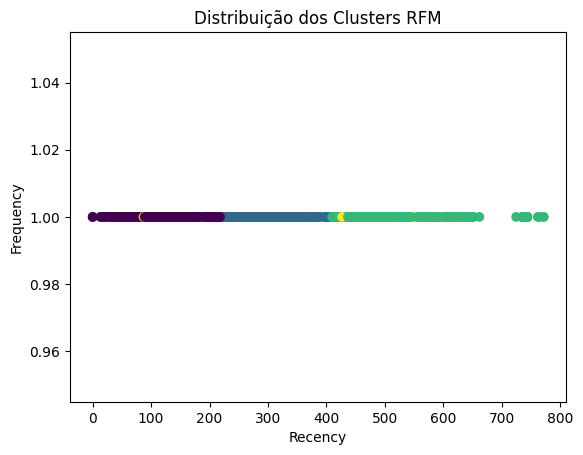

Cluster 0 - Descrição:
            Recency  Frequency      Monetary  Cluster
count  36559.000000    36559.0  36559.000000  36559.0
mean     136.076233        1.0    137.297746      0.0
std       49.993796        0.0    109.776192      0.0
min        0.000000        1.0      0.000000      0.0
25%       89.000000        1.0     62.280000      0.0
50%      137.000000        1.0    105.940000      0.0
75%      180.000000        1.0    173.610000      0.0
max      229.000000        1.0    685.880000      0.0


Cluster 1 - Descrição:
            Recency  Frequency      Monetary  Cluster
count  36861.000000    36861.0  36861.000000  36861.0
mean     304.204878        1.0    130.822814      1.0
std       51.717339        0.0    102.703331      0.0
min      218.000000        1.0     10.070000      1.0
25%      259.000000        1.0     60.690000      1.0
50%      307.000000        1.0    101.220000      1.0
75%      341.000000        1.0    166.290000      1.0
max      406.000000        1.0    

In [12]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Carregar dados
df_pedidos = pd.read_csv('../data/processed/pedidos.csv', parse_dates=['order_purchase_timestamp'])
df_pagamentos = pd.read_csv('../data/processed/pagamentos.csv', usecols=['order_id', 'payment_value'])

# Juntar valor de pagamento aos pedidos
pagamento_por_pedido = df_pagamentos.groupby('order_id')['payment_value'].sum().reset_index()
df_pedidos = df_pedidos.merge(pagamento_por_pedido, on='order_id', how='left')

# Calcular data de referência para recency
ref_date = df_pedidos['order_purchase_timestamp'].max()

# Calcular RFM
rfm = df_pedidos.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (ref_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Normalização
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Clustering com KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Análise de perfil dos clusters
print("\nMédia das métricas por cluster:\n")
print(rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2))

# Visualizar a distribuição dos clusters
plt.scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Distribuição dos Clusters RFM')
plt.show()

# Análise de perfil de cada cluster
for cluster in range(4):
    print(f"Cluster {cluster} - Descrição:")
    print(rfm[rfm['Cluster'] == cluster].describe())
    print("\n")

# Estratégias de marketing para cada cluster (exemplo)
# Cluster 0 (exemplo: alta frequência e baixo valor monetário)
print("Estratégia para Cluster 0 (Alta Frequência, Baixo Valor):")
print("Oferecer descontos para aumentar o valor médio das compras.")

# Cluster 1 (exemplo: alta recência, baixa frequência e baixo valor)
print("Estratégia para Cluster 1 (Alta Recência, Baixa Frequência):")
print("Investir em campanhas de retenção para aumentar a frequência de compras.")

# Cluster 2 (exemplo: alta frequência e alto valor)
print("Estratégia para Cluster 2 (Alta Frequência, Alto Valor):")
print("Programas de fidelidade ou recompensas para engajar ainda mais esses clientes.")

# Cluster 3 (exemplo: baixa recência, baixa frequência)
print("Estratégia para Cluster 3 (Baixa Recência, Baixa Frequência):")
print("Campanhas de reativação ou descontos especiais para atrair esses clientes de volta.")


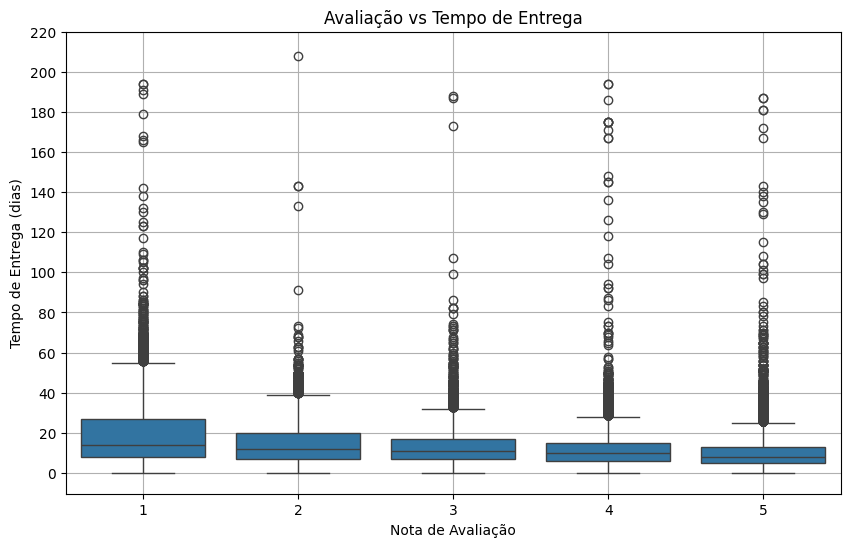

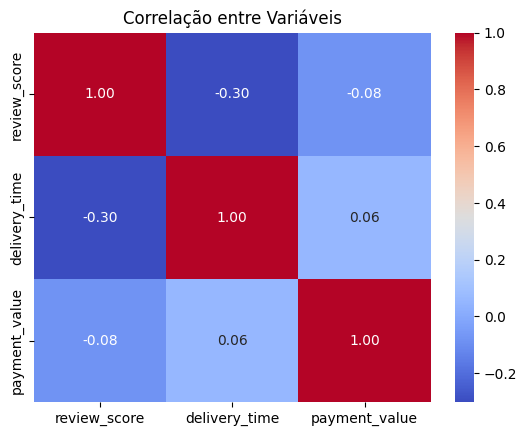

Coeficientes da regressão: [-0.04308228 -0.00032793]
Intercepto: 4.633113802955757


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Carregar dados
df_pedidos = pd.read_csv('../data/processed/pedidos.csv', parse_dates=['order_approved_at', 'order_delivered_customer_date'])
df_reviews = pd.read_csv('../data/processed/reviews.csv')
df_produtos = pd.read_csv('../data/processed/produtos.csv', usecols=['product_id', 'product_category_name'])
df_itens = pd.read_csv('../data/processed/itens.csv', usecols=['order_id', 'product_id'])
df_pagamentos = pd.read_csv('../data/processed/pagamentos.csv', usecols=['order_id', 'payment_value'])  # Carregar a coluna payment_value

# Merge pedidos + avaliações
df = pd.merge(df_pedidos, df_reviews, on='order_id')

# Merge com itens e produtos
df = pd.merge(df, df_itens, on='order_id')
df = pd.merge(df, df_produtos, on='product_id')

# Merge com pagamentos para adicionar a coluna payment_value
df = pd.merge(df, df_pagamentos, on='order_id')

# Calcular tempo de entrega
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_approved_at']).dt.days

# Remover entregas com tempo negativo (caso haja algum erro de dados)
df = df[df['delivery_time'] >= 0]

# Boxplot: Review Score vs Tempo de Entrega
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='delivery_time', data=df)
plt.title('Avaliação vs Tempo de Entrega')
plt.xlabel('Nota de Avaliação')
plt.ylabel('Tempo de Entrega (dias)')

# Ajustar o eixo Y para mostrar os intervalos de 20 em 20 dias
plt.yticks(range(0, int(df['delivery_time'].max()) + 20, 20))

plt.grid(True)
plt.show()

# Correlação entre variáveis
corr = df[['review_score', 'delivery_time', 'payment_value']].corr()  # Agora payment_value existe no DataFrame
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Variáveis')
plt.show()

# Regressão linear para prever a nota de avaliação
X_satisfaction = df[['delivery_time', 'payment_value']]
y_satisfaction = df['review_score']
reg = LinearRegression()
reg.fit(X_satisfaction, y_satisfaction)

# Coeficientes da regressão
print(f'Coeficientes da regressão: {reg.coef_}')
print(f'Intercepto: {reg.intercept_}')


Média da acurácia com validação cruzada: 0.9277642981274858


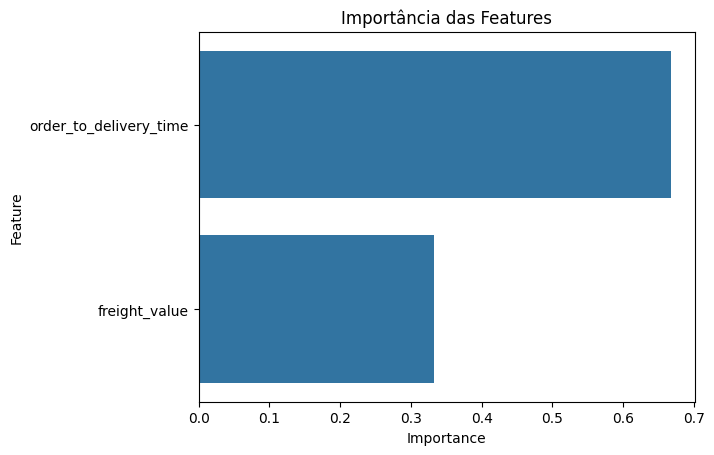

In [14]:
from sklearn.model_selection import cross_val_score

# Validação cruzada para avaliar o modelo
scores = cross_val_score(model, X, y, cv=5)
print(f'Média da acurácia com validação cruzada: {scores.mean()}')

# Visualizar a importância das features
importances = model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar a importância das features
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importância das Features')
plt.show()
